# 0 - Quick Imports

In [17]:
import numpy as np
import PIL
from PIL import Image
import numpy as np
import torch
import os
import sys

sys.path.append('..')
os.path.join(os.path.defpath)
import os

# Construct the path relative to home
project_path = os.path.join(os.path.expanduser('~'), 'project', 'grepa', 'REPA')
# Change the current working directory
os.chdir(project_path)
print(os.getcwd()) # confirm the working directory is the repo root

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/scratch3/zha439/project/grepa/REPA
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def display_alongside_batch(img_list, resize_dims=(512,512)):
    if isinstance(resize_dims, int):
        resize_dims = (resize_dims,resize_dims)
    res = np.concatenate([np.array(img.resize(resize_dims)) for img in img_list], axis=1)
    return Image.fromarray(res)

# 1 - Load the model (SiT) and encoder (DINO)

In [3]:
# --model SiT-XL/2 \
#   --num-fid-samples 50000 \
#   --ckpt YOUR_CHECKPOINT_PATH \
#   --path-type=linear \
#   --encoder-depth=8 \
#   --projector-embed-dims=768 \
#   --per-proc-batch-size=64 \
#   --mode=sde \
#   --num-steps=250 \
#   --cfg-scale=1.8 \
#   --guidance-high=0.7

# Load model:
from dataclasses import dataclass
from models.sit import SiT_models
from diffusers.models import AutoencoderKL

@dataclass
class repaArgs():
    vae = 'ema'
    model =  'SiT-XL/2' #'SiT-B/2' #'SiT-XL/2'
    num_classes = 1000
    encoder_depth = 8
    projector_embed_dims = "768"
    fused_attn = True
    qk_norm = False
    resolution = 256
    # ckpt = './exps/sit-b-base-400k/checkpoints/0250000.pt'
    # ckpt = './exps/sit-b-linear-dinov2-b-enc8-400k/checkpoints/0200000.pt'
    ckpt = './pretrained_models/last.pt'
    data_dir = './data/'
    
args = repaArgs()
device = "cuda:3"

block_kwargs = {"fused_attn": args.fused_attn, "qk_norm": args.qk_norm}
latent_size = args.resolution // 8
model = SiT_models[args.model](
    input_size=latent_size,
    num_classes=args.num_classes,
    use_cfg = True,
    z_dims = [int(z_dim) for z_dim in args.projector_embed_dims.split(',')],
    encoder_depth=args.encoder_depth,
    **block_kwargs,
).to(device)

# Auto-download a pre-trained model or load a custom SiT checkpoint from train.py:
ckpt_path = args.ckpt
state_dict = torch.load(ckpt_path, map_location=f'{device}')#['ema']
model.load_state_dict(state_dict)
model.eval()  # important!
vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-{args.vae}").to(device)

/scratch3/zha439/env/grepa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_31727/2159072858.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weig

In [4]:
model

SiT(
  (x_embedder): PatchEmbed(
    (proj): Conv2d(4, 1152, kernel_size=(2, 2), stride=(2, 2))
    (norm): Identity()
  )
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=1152, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1152, out_features=1152, bias=True)
    )
  )
  (y_embedder): LabelEmbedder(
    (embedding_table): Embedding(1001, 1152)
  )
  (blocks): ModuleList(
    (0-27): 28 x SiTBlock(
      (norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): Linear(in_features=1152, out_features=3456, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1152, out_features=1152, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((1152,), eps=1e-06, elementwise_affine=False)
      (mlp): Mlp(
        (fc1): Linear(in_features=11

In [5]:
for name, module in model.named_modules():
    print(name)


x_embedder
x_embedder.proj
x_embedder.norm
t_embedder
t_embedder.mlp
t_embedder.mlp.0
t_embedder.mlp.1
t_embedder.mlp.2
y_embedder
y_embedder.embedding_table
blocks
blocks.0
blocks.0.norm1
blocks.0.attn
blocks.0.attn.qkv
blocks.0.attn.q_norm
blocks.0.attn.k_norm
blocks.0.attn.attn_drop
blocks.0.attn.proj
blocks.0.attn.proj_drop
blocks.0.norm2
blocks.0.mlp
blocks.0.mlp.fc1
blocks.0.mlp.act
blocks.0.mlp.drop1
blocks.0.mlp.norm
blocks.0.mlp.fc2
blocks.0.mlp.drop2
blocks.0.adaLN_modulation
blocks.0.adaLN_modulation.0
blocks.0.adaLN_modulation.1
blocks.1
blocks.1.norm1
blocks.1.attn
blocks.1.attn.qkv
blocks.1.attn.q_norm
blocks.1.attn.k_norm
blocks.1.attn.attn_drop
blocks.1.attn.proj
blocks.1.attn.proj_drop
blocks.1.norm2
blocks.1.mlp
blocks.1.mlp.fc1
blocks.1.mlp.act
blocks.1.mlp.drop1
blocks.1.mlp.norm
blocks.1.mlp.fc2
blocks.1.mlp.drop2
blocks.1.adaLN_modulation
blocks.1.adaLN_modulation.0
blocks.1.adaLN_modulation.1
blocks.2
blocks.2.norm1
blocks.2.attn
blocks.2.attn.qkv
blocks.2.attn.

In [4]:
import torch
from PIL import Image
from samplers import euler_sampler, euler_maruyama_sampler
# Ensure your model and vae are already loaded as in your snippet
from utils.imagenet_idx_to_classnames import imagenet_idx_to_classnames

def sample_images(
    model, 
    vae, 
    class_idx=None,
    batch_size=8,
    resolution=256, 
    num_steps=50, 
    mode='ode', 
    cfg_scale=1.5, 
    guidance_low=0.0, 
    guidance_high=1.0, 
    path_type='linear', 
    num_classes=1000, 
    device='cuda'
):
    """
    Sample images from a SiT model in a simple single-GPU environment.
    
    Parameters:
        model: The loaded SiT model.
        vae: The loaded VAE model from diffusers.
        batch_size (int): Number of images to sample in one batch.
        resolution (int): The output resolution of images.
        num_steps (int): Number of diffusion steps (ODE or SDE steps).
        mode (str): 'ode' or 'sde' sampling mode.
        cfg_scale (float): Classifier-free guidance scale.
        guidance_low (float): Guidance lower bound.
        guidance_high (float): Guidance upper bound.
        path_type (str): 'linear' or 'cosine' for scheduling.
        num_classes (int): Number of classes for the model.
        device (str): Device to run the sampling on.
        
    Returns:
        A list of PIL.Image objects.
    """
    model.eval()
    latent_size = resolution // 8

    # Sample latent noise
    z = torch.randn(batch_size, model.in_channels, latent_size, latent_size, device=device)
    if class_idx:
        y = torch.tensor([class_idx] * batch_size, device=device)
    else:
        # Sample random class labels (if using an ImageNet-like model)
        y = torch.randint(0, num_classes, (batch_size,), device=device)
        
    # Prepare sampler arguments
    sampling_kwargs = dict(
        model=model,
        latents=z,
        y=y, # label condition
        num_steps=num_steps,
        heun=False,  # Set True if you want Heun steps (for ODE sampler)
        cfg_scale=cfg_scale,
        guidance_low=guidance_low,
        guidance_high=guidance_high,
        path_type=path_type,
    )

    with torch.no_grad():
        # Pick the sampler
        if mode == "sde":
            samples = euler_maruyama_sampler(**sampling_kwargs).to(torch.float32)
        elif mode == "ode":
            samples = euler_sampler(**sampling_kwargs).to(torch.float32)
        else:
            raise NotImplementedError("Mode must be 'ode' or 'sde'.")

        # Decode with VAE
        latents_scale = torch.tensor([0.18215]*4).view(1,4,1,1).to(device)
        latents_bias = torch.tensor([0.0]*4).view(1,4,1,1).to(device)
        decoded = vae.decode((samples - latents_bias) / latents_scale).sample
        decoded = (decoded + 1) / 2.0
        decoded = torch.clamp(255. * decoded, 0, 255).permute(0,2,3,1).to("cpu", dtype=torch.uint8).numpy()

    class_idxs = y.detach().cpu().numpy()
    # Convert to PIL images
    images = [Image.fromarray(decoded[i]) for i in range(decoded.shape[0])]
    return images, class_idxs

cheetah, chetah, Acinonyx jubatus


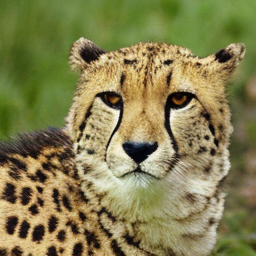

coucal


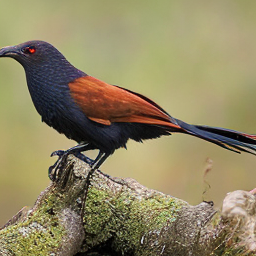

coral fungus


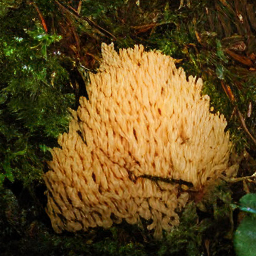

cello, violoncello


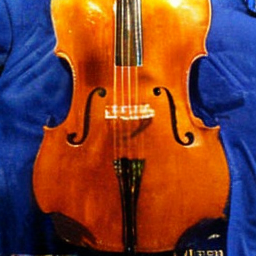

['cheetah, chetah, Acinonyx jubatus', 'coucal', 'coral fungus', 'cello, violoncello']


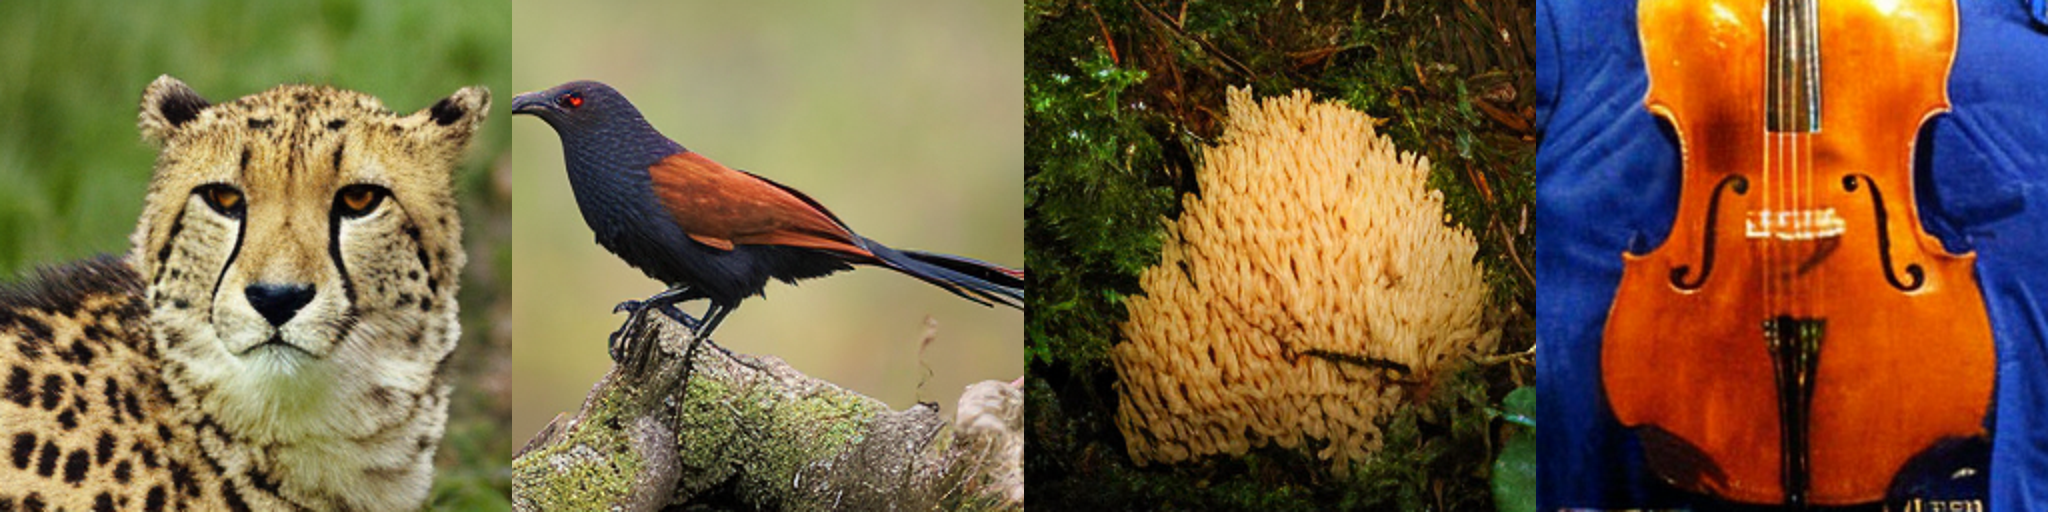

In [5]:
from utils.imagenet_idx_to_classnames import imagenet_idx_to_classnames

# generate samples
device = "cuda:3"  # or "cpu"
class_idx = None #2 #None

images, class_idxs = sample_images(
    model=model, 
    vae=vae,
    class_idx=class_idx,
    batch_size=4, 
    resolution=256, 
    num_steps=100, 
    mode='ode', 
    cfg_scale=2.5, 
    guidance_low=0.0, 
    guidance_high=1.0, 
    path_type='linear', 
    num_classes=1000,
    device=device
)

class_names = [imagenet_idx_to_classnames[x] for x in class_idxs]
if class_idx is None:
    # Display the sampled images directly in the notebook
    for img, class_name in zip(images, class_names):
        print (class_name)
        display(img)

print (class_names)
display_alongside_batch(images)

In [6]:
imagenet_idx_to_classnames

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

## 1.2 - Extract DINO and Diffusion features

In [4]:
from dataclasses import dataclass
from typing import Literal

@dataclass
class repaArgs:
    # Logging and I/O
    output_dir: str = "exps"
    exp_name: str = "my_experiment"  # originally required; provide a default
    logging_dir: str = "logs"
    report_to: str = "wandb"
    sampling_steps: int = 10000
    resume_step: int = 0

    # Model
    model: str = "SiT-XL/2"
    num_classes: int = 1000
    encoder_depth: int = 8
    fused_attn: bool = True
    qk_norm: bool = False

    # Dataset
    data_dir: str = "./data/"
    resolution: int = 256
    batch_size: int = 256

    # Precision
    allow_tf32: bool = False
    mixed_precision: Literal["no", "fp16", "bf16"] = "fp16"

    # Optimization
    epochs: int = 1400
    max_train_steps: int = 400000
    checkpointing_steps: int = 40000
    gradient_accumulation_steps: int = 1
    learning_rate: float = 1e-4
    adam_beta1: float = 0.9
    adam_beta2: float = 0.999
    adam_weight_decay: float = 0.0
    adam_epsilon: float = 1e-08
    max_grad_norm: float = 1.0

    # Seed
    seed: int = 0

    # CPU-related
    num_workers: int = 4

    # Loss
    path_type: Literal["linear", "cosine"] = "linear"
    prediction: Literal["v"] = "v"  # currently only 'v' supported
    cfg_prob: float = 0.1
    enc_type: str = "dinov2-vit-b"
    proj_coeff: float = 0.5
    weighting: str = "uniform"
    legacy: bool = False

    # Additional model/vae params from your initial snippet
    vae: str = "ema"
    projector_embed_dims: str = "768"
    ckpt: str = "./pretrained_models/last.pt"

# train dataset
from dataset import CustomDataset, CustomZipDataset, CustomH5Dataset

def load_train_dataset(args):
    if (os.path.exists(os.path.join(args.data_dir, "images")) and
        os.path.exists(os.path.join(args.data_dir, "vae-sd"))):
        train_dataset = CustomDataset(args.data_dir)
    elif (os.path.exists(os.path.join(args.data_dir, "images.h5")) and
          os.path.exists(os.path.join(args.data_dir, "vae-sd.h5")) and
          os.path.exists(os.path.join(args.data_dir, "images_h5.json")) and
          os.path.exists(os.path.join(args.data_dir, "vae-sd_h5.json"))):
            train_dataset = CustomH5Dataset(args.data_dir)
    elif (os.path.exists(os.path.join(args.data_dir, "images.zip")) and
          os.path.exists(os.path.join(args.data_dir, "vae-sd.zip"))):
        train_dataset = CustomZipDataset(args.data_dir)
    else:
        raise ValueError("Dataset not found.")
    return train_dataset

from utils import load_encoders
def load_perception_encoders(args):
    if args.enc_type != 'None':
        encoders, encoder_types, architectures = load_encoders(args.enc_type, device)
    else:
        encoders, encoder_types, architectures = [None], [None], [None]
    return encoders, encoder_types, architectures
    
from loss import SILoss
def get_loss_fn(args):
    # create loss function
    loss_fn = SILoss(
        prediction=args.prediction,
        path_type=args.path_type, 
        encoders=encoders,
        accelerator=None, # since we only need the interpolation fn
        latents_scale=None,# since we only need the interpolation fn
        latents_bias=None,# since we only need the interpolation fn
        weighting=args.weighting,
        loss_type=None,
    )
    return loss_fn

In [5]:
# load args and training dataset
args = repaArgs()
print(args)

repaArgs(output_dir='exps', exp_name='my_experiment', logging_dir='logs', report_to='wandb', sampling_steps=10000, resume_step=0, model='SiT-XL/2', num_classes=1000, encoder_depth=8, fused_attn=True, qk_norm=False, data_dir='./data/', resolution=256, batch_size=256, allow_tf32=False, mixed_precision='fp16', epochs=1400, max_train_steps=400000, checkpointing_steps=40000, gradient_accumulation_steps=1, learning_rate=0.0001, adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, seed=0, num_workers=4, path_type='linear', prediction='v', cfg_prob=0.1, enc_type='dinov2-vit-b', proj_coeff=0.5, weighting='uniform', legacy=False, vae='ema', projector_embed_dims='768', ckpt='./pretrained_models/last.pt')


In [6]:
args.enc_type, device

('dinov2-vit-b', 'cuda:3')

In [7]:
# get training dataset, encoders and loss_fn
train_dataset = load_train_dataset(args)  # Uses args.data_dir
encoders, encoder_types, architectures = load_perception_encoders(args)
loss_fn = get_loss_fn(args)

Using cache found in /home/zha439/.cache/torch/hub/facebookresearch_dinov2_main
/home/zha439/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/zha439/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/zha439/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [24]:
import torch
from torch.utils.data import DataLoader
from train import sample_posterior, preprocess_raw_image

# Model should be in eval mode if we're just extracting features
model.eval()

def get_batch_features(
    model, 
    vae, 
    encoders, 
    encoder_types, 
    architectures, 
    train_dataset, 
    loss_fn,
    device='cuda', 
    batch_size=8,
    use_projection=True, 
    t_start=0.,
    t_end=1.,
):
    # Setup scale/bias for latents
    latents_scale = torch.tensor([0.18215]*4).view(1,4,1,1).to(device)
    latents_bias = torch.tensor([0.0]*4).view(1,4,1,1).to(device)

    # Get one batch
    temp_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    raw_image, x, y = next(iter(temp_loader))
    raw_image = raw_image.to(device)
    x = x.squeeze(dim=1).to(device)
    y = y.to(device)

    # If needed, handle cfg_prob / legacy label dropping here. For simplicity:
    labels = y

    with torch.no_grad():
        # Convert VAE latents to model latents
        x = sample_posterior(x, latents_scale=latents_scale, latents_bias=latents_bias)

        # Extract encoder features
        zs = []
        for encoder, encoder_type, arch in zip(encoders, encoder_types, architectures):
            raw_image_ = preprocess_raw_image(raw_image, encoder_type)
            z = encoder.forward_features(raw_image_)
            if 'mocov3' in encoder_type:
                z = z[:, 1:]
            if 'dinov2' in encoder_type:
                z = z['x_norm_patchtokens']
            zs.append(z)

        # Sample a random time step (uniform weighting)
        time_input = torch.rand((x.shape[0], 1, 1, 1), device=device, dtype=x.dtype)
        # limit to the given range
        time_input = time_input * (t_end - t_start) + t_start
        
        alpha_t, sigma_t, d_alpha_t, d_sigma_t = loss_fn.interpolant(time_input)
        noises = torch.randn_like(x)
        model_input = alpha_t * x + sigma_t * noises
        model_target = d_alpha_t * x + d_sigma_t * noises

        # Forward pass through the model to get zs_tilde and predictions
        model_output, zs_tilde, fs , all_layer_feats = model(model_input, time_input.flatten(), y=labels, use_projection=use_projection)

    return {
        "raw_image": raw_image,
        "model_input": model_input,
        "zs": zs,
        "zs_tilde": zs_tilde,
        "model_output": model_output,
        "time_input": time_input,
        "model_target": model_target,
        'fs': fs,
        'all_layer_feats': all_layer_feats,
    }

In [12]:
# Example usage in a Jupyter cell:
model.encoder_depth = args.encoder_depth
features = get_batch_features(
    model=model,
    vae=vae,
    encoders=encoders,
    encoder_types=encoder_types,
    architectures=architectures,
    train_dataset=train_dataset,
    loss_fn=loss_fn,
    device=device,
    batch_size=256,
    t_start=0.,
    t_end=1.,
)

In [199]:
# # Printing the requested details nicely
# print("Keys in features:\n", list(features.keys()), "\n")

# print(f"Shape of raw_image:\n{features['raw_image'].shape}\n")

# print("Shapes of model_input, model_output, model_target:\n", f"{features['model_input'].shape}, {features['model_output'].shape}, {features['model_target'].shape}\n")

# print(f"Lengths of zs and zs_tilde:\n{len(features['zs'])}, {len(features['zs_tilde'])}\n")

# print("Shapes of first elements in zs and zs_tilde:\n", 
#       f"{features['zs'][0].shape}, {features['zs_tilde'][0].shape}\n")

In [13]:
features.keys()

dict_keys(['raw_image', 'model_input', 'zs', 'zs_tilde', 'model_output', 'time_input', 'model_target'])

In [14]:
features['raw_image'].shape

torch.Size([256, 3, 256, 256])

In [15]:
# vae style features but for different timesteps
features['model_input'].shape, features['model_output'].shape, features['model_target'].shape

(torch.Size([256, 4, 32, 32]),
 torch.Size([256, 4, 32, 32]),
 torch.Size([256, 4, 32, 32]))

In [16]:
len(features['zs']), len(features['zs_tilde'])

(1, 1)

In [17]:
# encoder (dino) and  diffusion features (after projection)
features['zs'][0].shape, features['zs_tilde'][0].shape

(torch.Size([256, 256, 768]), torch.Size([256, 256, 768]))

In [18]:
features['time_input'].shape

torch.Size([256, 1, 1, 1])

In [19]:
# alignment score
from metrics import AlignmentMetrics
feat_A = features['zs'][0].mean(dim=1) # B, D
feat_B = features['zs_tilde'][0].mean(dim=1) # # B, D
alignment_score = AlignmentMetrics.measure('cknna', feat_A, feat_B, topk=10)

In [20]:
alignment_score

0.5586867112380596

# 2 - Analyse feature alignment and correlation with model performance

In [21]:
from metrics import AlignmentMetrics

a = torch.randn(4,2,2)
# AlignmentMetrics.patch2patch_kernel_alignment_score_jsd(a, a)
AlignmentMetrics.sample2sample_kernel_alignment_score_jsd(a, a)

1.0

In [54]:
from metrics import AlignmentMetrics

def get_alignment_score(layer_idx=8, batch_size=8, topk=2, use_projection=True, t_start=0., t_end=1., temp=1.):
    # change layer idx for extracting features from the 
    model.encoder_depth = layer_idx
    
    # extract features
    features = get_batch_features(
        model=model,
        vae=vae,
        encoders=encoders,
        encoder_types=encoder_types,
        architectures=architectures,
        train_dataset=train_dataset,
        loss_fn=loss_fn,
        device=device,
        batch_size=batch_size,
        use_projection=use_projection,
        t_start=t_start,
        t_end=t_end,
    )

    # compute alignment score
    # alignment score
    feat_A = features['zs'][0]#.mean(dim=1) # B, D
    feat_B = features['zs_tilde'][0]#.mean(dim=1) # # B, D
    # alignment_score = AlignmentMetrics.measure('cknna', feat_A, feat_B, topk=topk)
    # alignment_score = AlignmentMetrics.patch2patch_kernel_alignment_score(feat_A, feat_B)
    # alignment_score = AlignmentMetrics.sample2sample_kernel_alignment_score(feat_A, feat_B)
    # alignment_score = AlignmentMetrics.patch2patch_kernel_alignment_score_jsd(feat_A, feat_B, temperature=temp)
    alignment_score = AlignmentMetrics.sample2sample_kernel_alignment_score_jsd(feat_A, feat_B, temperature=temp)
    # alignment_score = patch2patch_kernel_alignment_score(feat_A, feat_B)
    return alignment_score

In [64]:
# Import necessary libraries
import matplotlib.pyplot as plt
from tqdm import tqdm

# hyperparams
batch_size=128
topk=10
layer_start=6
layer_end=10
use_projection = False
t_start = 0.49
t_end = 0.51
temp = 0.2

alignment_scores = []
# Compute alignment scores with tqdm for progress
for layer_idx in tqdm(range(layer_start,layer_end), desc="Computing Alignment Scores"):
    score = get_alignment_score(layer_idx=layer_idx, batch_size=batch_size, topk=topk, use_projection=use_projection, t_start=t_start, t_end=t_end,temp=temp)
    alignment_scores.append(score)


omputing Alignment Scores: 100%|███████████████████████| 4/4 [00:28<00:00,  7.17s/it]

In [65]:
alignment_scores

[0.7544994950294495,
 0.7687934041023254,
 0.9797963500022888,
 0.7557803988456726]

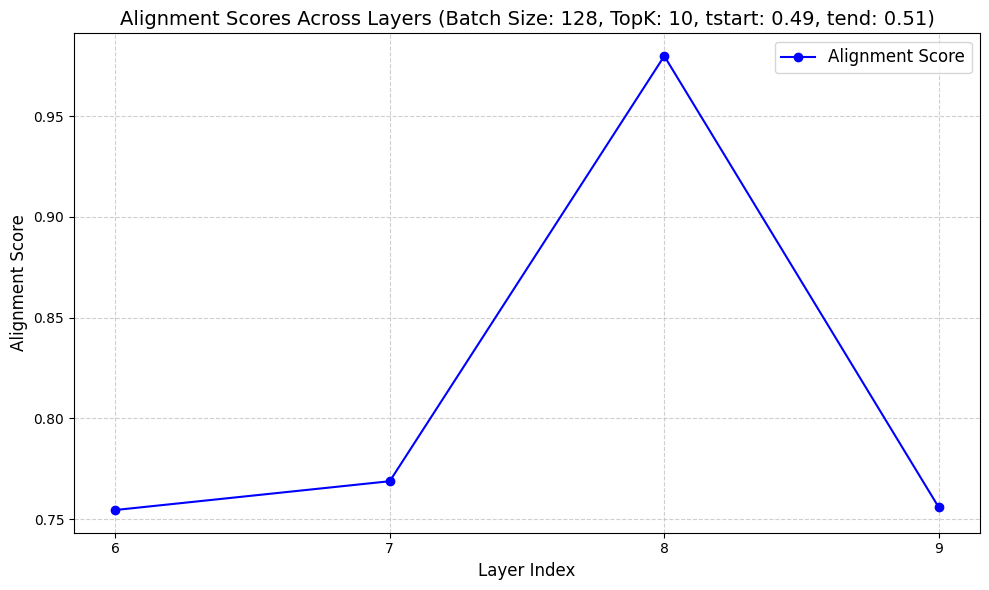

In [66]:
# Plot the alignment scores
plt.figure(figsize=(10, 6))
plt.plot(range(layer_start,layer_end), alignment_scores, marker='o', linestyle='-', color='b', label='Alignment Score')
plt.title(f"Alignment Scores Across Layers (Batch Size: {batch_size}, TopK: {topk}, tstart: {t_start}, tend: {t_end})", fontsize=14)
plt.xlabel("Layer Index", fontsize=12)
plt.ylabel("Alignment Score", fontsize=12)
# plt.ylim(0, 1)
plt.xticks(range(layer_start, layer_end, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 3 - Design kernel alignment metric and loss

In [61]:
import torch
import torch.nn as nn
import math

class GradientRecorder:
    def __init__(self, model, layer_name):
        """
        Initialize the GradientRecorder.

        Args:
            model (nn.Module): The model containing the target layer.
            layer_name (str): The name of the layer to hook.
        """
        self.gradients = {}
        self.hook_handles = []
        self._register_hooks(model, layer_name)

    def _register_hooks(self, model, layer_name):
        """
        Register backward hooks to the specified layer.

        Args:
            model (nn.Module): The model containing the target layer.
            layer_name (str): The name of the layer to hook.
        """
        # Retrieve the layer by name
        target_layer = dict([*model.named_modules()]).get(layer_name, None)
        if target_layer is None:
            raise ValueError(f"Layer {layer_name} not found in the model.")

        # Define the hook function
        def hook_fn(module, grad_input, grad_output):
            # Assuming grad_output is a tuple with one element
            self.gradients[layer_name] = grad_output[0].detach().clone()

        # Register the backward hook
        handle = target_layer.register_backward_hook(hook_fn)
        self.hook_handles.append(handle)

    def remove_hooks(self):
        """Remove all registered hooks."""
        for handle in self.hook_handles:
            handle.remove()

# 4 - Optimize training

## 4.2 - Analyse the angle between the diffusion loss gradients and the dino reg loss gradients

In [3]:
from dataclasses import dataclass
from typing import Literal
# Load model:
from models.sit import SiT_models
from diffusers.models import AutoencoderKL

@dataclass
class repaArgs:
    # Logging and I/O
    output_dir: str = "exps"
    exp_name: str = "my_experiment"  # originally required; provide a default
    logging_dir: str = "logs"
    report_to: str = "wandb"
    sampling_steps: int = 10000
    resume_step: int = 0

    # Model
    model: str = "SiT-XL/2"
    num_classes: int = 1000
    encoder_depth: int = 8
    fused_attn: bool = True
    qk_norm: bool = False

    # Dataset
    data_dir: str = "./data/"
    resolution: int = 256
    batch_size: int = 256

    # Precision
    allow_tf32: bool = False
    mixed_precision: Literal["no", "fp16", "bf16"] = "fp16"

    # Optimization
    epochs: int = 1400
    max_train_steps: int = 400000
    checkpointing_steps: int = 40000
    gradient_accumulation_steps: int = 1
    learning_rate: float = 1e-4
    adam_beta1: float = 0.9
    adam_beta2: float = 0.999
    adam_weight_decay: float = 0.0
    adam_epsilon: float = 1e-08
    max_grad_norm: float = 1.0

    # Seed
    seed: int = 0

    # CPU-related
    num_workers: int = 4

    # Loss
    path_type: Literal["linear", "cosine"] = "linear"
    prediction: Literal["v"] = "v"  # currently only 'v' supported
    cfg_prob: float = 0.1
    enc_type: str = "dinov2-vit-b"
    proj_coeff: float = 0.5
    weighting: str = "uniform"
    legacy: bool = False

    # Additional model/vae params from your initial snippet
    vae: str = "ema"
    projector_embed_dims: str = "768"
    ckpt: str = "./pretrained_models/last.pt"

# train dataset
from dataset import CustomDataset, CustomZipDataset, CustomH5Dataset

def load_train_dataset(args):
    if (os.path.exists(os.path.join(args.data_dir, "images")) and
        os.path.exists(os.path.join(args.data_dir, "vae-sd"))):
        train_dataset = CustomDataset(args.data_dir)
    elif (os.path.exists(os.path.join(args.data_dir, "images.h5")) and
          os.path.exists(os.path.join(args.data_dir, "vae-sd.h5")) and
          os.path.exists(os.path.join(args.data_dir, "images_h5.json")) and
          os.path.exists(os.path.join(args.data_dir, "vae-sd_h5.json"))):
            train_dataset = CustomH5Dataset(args.data_dir)
    elif (os.path.exists(os.path.join(args.data_dir, "images.zip")) and
          os.path.exists(os.path.join(args.data_dir, "vae-sd.zip"))):
        train_dataset = CustomZipDataset(args.data_dir)
    else:
        raise ValueError("Dataset not found.")
    return train_dataset

from utils import load_encoders
def load_perception_encoders(args):
    if args.enc_type != 'None':
        encoders, encoder_types, architectures = load_encoders(args.enc_type, device)
    else:
        encoders, encoder_types, architectures = [None], [None], [None]
    return encoders, encoder_types, architectures
    
from loss import SILoss
def get_loss_fn(args):
    # create loss function
    loss_fn = SILoss(
        prediction=args.prediction,
        path_type=args.path_type, 
        encoders=encoders,
        accelerator=None, # since we only need the interpolation fn
        latents_scale=None,# since we only need the interpolation fn
        latents_bias=None,# since we only need the interpolation fn
        weighting=args.weighting,
        loss_type=None,
    )
    return loss_fn

def load_models(args):
    # load models
    block_kwargs = {"fused_attn": args.fused_attn, "qk_norm": args.qk_norm}
    latent_size = args.resolution // 8
    model = SiT_models[args.model](
        input_size=latent_size,
        num_classes=args.num_classes,
        use_cfg = True,
        z_dims = [int(z_dim) for z_dim in args.projector_embed_dims.split(',')],
        encoder_depth=args.encoder_depth,
        **block_kwargs,
    ).to(device)
    
    # Auto-download a pre-trained model or load a custom SiT checkpoint from train.py:
    ckpt_path = args.ckpt
    state_dict = torch.load(ckpt_path, map_location=f'{device}')#['ema']
    model.load_state_dict(state_dict)
    model.eval()  # important!
    vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-{args.vae}").to(device)
    return model, vae

/scratch3/zha439/env/grepa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# load args and training dataset
device = 'cuda:3'
args = repaArgs()
print(args)

repaArgs(output_dir='exps', exp_name='my_experiment', logging_dir='logs', report_to='wandb', sampling_steps=10000, resume_step=0, model='SiT-XL/2', num_classes=1000, encoder_depth=8, fused_attn=True, qk_norm=False, data_dir='./data/', resolution=256, batch_size=256, allow_tf32=False, mixed_precision='fp16', epochs=1400, max_train_steps=400000, checkpointing_steps=40000, gradient_accumulation_steps=1, learning_rate=0.0001, adam_beta1=0.9, adam_beta2=0.999, adam_weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, seed=0, num_workers=4, path_type='linear', prediction='v', cfg_prob=0.1, enc_type='dinov2-vit-b', proj_coeff=0.5, weighting='uniform', legacy=False, vae='ema', projector_embed_dims='768', ckpt='./pretrained_models/last.pt')


In [5]:
args.enc_type, device

('dinov2-vit-b', 'cuda:3')

In [ ]:
# get training dataset, encoders and loss_fn
model, vae = load_models(args)
train_dataset = load_train_dataset(args)  # Uses args.data_dir
encoders, encoder_types, architectures = load_perception_encoders(args)
loss_fn = get_loss_fn(args)

/tmp/ipykernel_71183/3990568259.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location=f'{device}')#['ema']


In [8]:
import torch
import torch.nn as nn
import math

class GradientRecorder:
    def __init__(self, model, layer_name):
        """
        Initialize the GradientRecorder.

        Args:
            model (nn.Module): The model containing the target layer.
            layer_name (str): The hierarchical name of the layer to hook.
        """
        self.gradients_diffusion = None
        self.gradients_projection = None
        self.hook_handle = None
        self.layer_name = layer_name
        self.mode = None  # 'diffusion' or 'projection'
        self._register_hook(model)

    def _register_hook(self, model):
        """
        Register a single backward hook to the specified layer.

        Args:
            model (nn.Module): The model containing the target layer.
        """
        # Retrieve the layer by hierarchical name
        target_layer = dict([*model.named_modules()]).get(self.layer_name, None)
        if target_layer is None:
            raise ValueError(f"Layer '{self.layer_name}' not found in the model.")

        def hook_fn(module, grad_input, grad_output):
            if self.mode == 'diffusion':
                self.gradients_diffusion = grad_output[0].detach().clone()
            elif self.mode == 'projection':
                self.gradients_projection = grad_output[0].detach().clone()

        # Register the backward hook
        self.hook_handle = target_layer.register_backward_hook(hook_fn)

    def set_mode(self, mode):
        """
        Set the current mode for gradient recording.

        Args:
            mode (str): 'diffusion' or 'projection'
        """
        if mode not in ['diffusion', 'projection']:
            raise ValueError("Mode should be either 'diffusion' or 'projection'")
        self.mode = mode

    def get_gradients(self):
        """
        Get the recorded gradients.

        Returns:
            dict: {'diffusion_grad': tensor, 'projection_grad': tensor}
        """
        return {
            "diffusion_grad": self.gradients_diffusion,
            "projection_grad": self.gradients_projection
        }

    def clear_gradients(self):
        """
        Clear the stored gradients.
        """
        self.gradients_diffusion = None
        self.gradients_projection = None

    def remove_hooks(self):
        """Remove the registered hook."""
        if self.hook_handle is not None:
            self.hook_handle.remove()

In [9]:
def compute_gradients(
    model, vae, encoders, encoder_types, architectures, loss_fn, dataloader, 
    gradient_recorder, device='cuda', use_projection=True, t_start=0., t_end=1.
):
    """
    Compute gradients for diffusion loss and projection loss.

    Args:
        model (nn.Module): The SiT model.
        vae (AutoencoderKL): The VAE model.
        encoders (list): List of encoder models.
        encoder_types (list): List of encoder types.
        architectures (list): List of architectures.
        loss_fn (SILoss): The loss function.
        dataloader (DataLoader): The DataLoader instance.
        gradient_recorder (GradientRecorder): Instance to record gradients.
        device (str): Device to run computations on.
        use_projection (bool): Whether to use projection in the model.
        t_start (float): Start of time interval.
        t_end (float): End of time interval.

    Returns:
        dict: Dictionary containing gradients for diffusion and projection losses.
    """
    # Fetch a batch
    try:
        raw_image, x, y = next(iter(dataloader))
    except StopIteration:
        raise ValueError("DataLoader is empty or has been exhausted.")
    raw_image = raw_image.to(device)
    x = x.squeeze(dim=1).to(device)
    y = y.to(device)

    # Handle label dropping if needed
    labels = y  # Adjust if using label dropping

    # Prepare inputs
    with torch.no_grad():
        x = sample_posterior(
            x, 
            latents_scale=torch.tensor([0.18215]*4).view(1,4,1,1).to(device),
            latents_bias=torch.tensor([0.0]*4).view(1,4,1,1).to(device)
        )
        zs = []
        with torch.autocast(device_type=device, dtype=torch.float16):
            for encoder, encoder_type, arch in zip(encoders, encoder_types, architectures):
                raw_image_ = preprocess_raw_image(raw_image, encoder_type)
                z = encoder.forward_features(raw_image_)
                if 'mocov3' in encoder_type:
                    z = z[:, 1:]
                if 'dinov2' in encoder_type:
                    z = z['x_norm_patchtokens']
                zs.append(z)

    # Ensure model is in training mode
    model.train()

    # Zero existing gradients
    model.zero_grad()

    # Forward pass to compute losses
    loss_components = loss_fn(
        model, x, model_kwargs={"y": labels}, zs=zs,
        alignment_kwargs={
            "compute_alignment": False, 
            "log_alignment_metrics": [], 
            "max_score_across_layers": False, 
            "cknna_topk": 10, 
            "p2p_jsd_temp": 0.1, 
            "s2s_jsd_temp": 0.2
        }
    )
    denoising_loss, proj_loss, ka_loss, _ = loss_components

    # Ensure losses are scalar
    denoising_loss = denoising_loss.mean()
    proj_loss = proj_loss.mean()

    # Clear previous gradients
    gradient_recorder.clear_gradients()

    # Backward pass for projection loss
    gradient_recorder.set_mode('projection')
    proj_loss.backward(retain_graph=True)
    try:
        grad_proj = gradient_recorder.gradients_projection.clone()
    except:
        grad_proj = None
    
    # Zero gradients before next backward pass
    model.zero_grad()

    # Backward pass for diffusion loss
    gradient_recorder.set_mode('diffusion')
    denoising_loss.backward(retain_graph=True)
    try:
        grad_diff = gradient_recorder.gradients_diffusion.clone()
    except:
        grad_diff = None

    return {
        "diffusion_grad": grad_diff,
        "projection_grad": grad_proj
    }

In [10]:
def compute_gradient_angle(grad1, grad2):
    """
    Compute the angle between two gradients in degrees.

    Args:
        grad1 (torch.Tensor): Gradient tensor 1.
        grad2 (torch.Tensor): Gradient tensor 2.

    Returns:
        float: Angle in degrees between the two gradients.
    """
    # Ensure gradients are flattened
    try:
        grad1_flat = grad1.view(-1)
        grad2_flat = grad2.view(-1)
    
        # Compute dot product and magnitudes
        dot_product = torch.dot(grad1_flat, grad2_flat)
        mag1 = torch.norm(grad1_flat)
        mag2 = torch.norm(grad2_flat)
    
        # Avoid division by zero
        if mag1.item() == 0 or mag2.item() == 0:
            return float('nan')
    
        # Compute cosine of the angle
        cos_theta = dot_product / (mag1 * mag2)
    
        # Clamp for numerical stability
        cos_theta = torch.clamp(cos_theta, -1.0, 1.0)
    
        # Compute angle in degrees
        angle = math.degrees(torch.acos(cos_theta).item())
    except:
        angle = np.nan

    return angle

In [11]:
import torch
import math
from torch.utils.data import DataLoader

# Assume `args`, `model`, `vae`, `encoders`, `encoder_types`, `architectures`, `loss_fn`, and `train_dataset` are already defined
batch_size = 64

# Initialize DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)

In [22]:
from train import sample_posterior, preprocess_raw_image

# Initialize GradientRecorder with the correct layer name
layer_name = "blocks.7"  # Replace with your actual layer name
gradient_recorder = GradientRecorder(model, layer_name)

# Compute Gradients
gradients = compute_gradients(
    model=model, 
    vae=vae, 
    encoders=encoders, 
    encoder_types=encoder_types, 
    architectures=architectures, 
    loss_fn=loss_fn, 
    dataloader=train_dataloader, 
    gradient_recorder=gradient_recorder, 
    device=device, 
    use_projection=True, 
    t_start=0.09,
    t_end=0.11,
)

# Retrieve gradients
grad_diff = gradients["diffusion_grad"]
grad_proj = gradients["projection_grad"]

# Compute Angle
if grad_diff is not None and grad_proj is not None:
    angle = compute_gradient_angle(grad_diff, grad_proj)
    print(f"Angle between diffusion and projection gradients: {angle:.2f} degrees")
else:
    print("Gradients not found. Ensure that the hooks are correctly registered and the target layer name is accurate.")

# Clean up hooks
gradient_recorder.remove_hooks()

Angle between diffusion and projection gradients: 89.40 degrees


In [14]:
from train import sample_posterior, preprocess_raw_image

def get_grad_angle(model, layer_name):
    # Initialize GradientRecorder with the correct layer name
    gradient_recorder = GradientRecorder(model, layer_name)
    
    # Compute Gradients
    gradients = compute_gradients(
        model=model, 
        vae=vae, 
        encoders=encoders, 
        encoder_types=encoder_types, 
        architectures=architectures, 
        loss_fn=loss_fn, 
        dataloader=train_dataloader, 
        gradient_recorder=gradient_recorder, 
        device=device, 
        use_projection=True, 
        t_start=0.09,
        t_end=0.11,
    )
    
    # Retrieve gradients
    grad_diff = gradients["diffusion_grad"]
    grad_proj = gradients["projection_grad"]
    
    # Compute Angle
    if grad_diff is not None and grad_proj is not None:
        angle = compute_gradient_angle(grad_diff, grad_proj)
        print(f"Layer name: {layer_name} ... Angle between diffusion and projection gradients: {angle:.2f} degrees")
    else:
        angle = -1
        print("Gradients not found. Ensure that the hooks are correctly registered and the target layer name is accurate.")
    
    # Clean up hooks
    gradient_recorder.remove_hooks()
    return angle

In [34]:
cos_sim = []
for layer_idx in range(1,10):
    # Initialize GradientRecorder with the correct layer name
    layer_name = f"blocks.{layer_idx}"  # Replace with your actual layer name
    angle = get_grad_angle(model, layer_name)
    cos_sim.append(angle)

/scratch3/zha439/env/grepa/lib/python3.9/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Layer name: blocks.1 ... Angle between diffusion and projection gradients: 76.47 degrees
Layer name: blocks.2 ... Angle between diffusion and projection gradients: 69.13 degrees
Layer name: blocks.3 ... Angle between diffusion and projection gradients: 70.98 degrees
Layer name: blocks.4 ... Angle between diffusion and projection gradients: 67.19 degrees
Layer name: blocks.5 ... Angle between diffusion and projection gradients: 75.19 degrees
Layer name: blocks.6 ... Angle between diffusion and projection gradients: 84.85 degrees
Layer name: blocks.7 ... Angle between diffusion and projection gradients: 89.22 degrees
Gradients not found. Ensure that the hooks are correctly registered and the target layer name is accurate.


UnboundLocalError: local variable 'angle' referenced before assignment

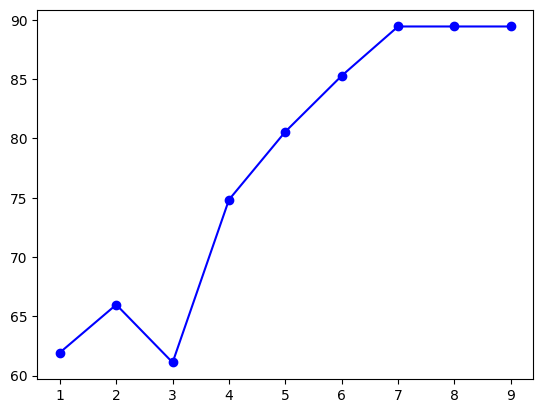

In [28]:
import matplotlib.pyplot as plt
plt.plot(range(1, 10), cos_sim, marker='o', linestyle='-', color='b', label='Alignment angle')

In [22]:
# Load different model checkpoints and see the trend
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm

@dataclass
class repaArgs:
    # Logging and I/O
    output_dir: str = "exps"
    exp_name: str = "my_experiment"  # originally required; provide a default
    logging_dir: str = "logs"
    report_to: str = "wandb"
    sampling_steps: int = 10000
    resume_step: int = 0

    # Model
    model: str = "SiT-XL/2"
    num_classes: int = 1000
    encoder_depth: int = 8
    fused_attn: bool = True
    qk_norm: bool = False

    # Dataset
    data_dir: str = "./data/"
    resolution: int = 256
    batch_size: int = 256

    # Precision
    allow_tf32: bool = False
    mixed_precision: Literal["no", "fp16", "bf16"] = "fp16"

    # Optimization
    epochs: int = 1400
    max_train_steps: int = 400000
    checkpointing_steps: int = 40000
    gradient_accumulation_steps: int = 1
    learning_rate: float = 1e-4
    adam_beta1: float = 0.9
    adam_beta2: float = 0.999
    adam_weight_decay: float = 0.0
    adam_epsilon: float = 1e-08
    max_grad_norm: float = 1.0

    # Seed
    seed: int = 0

    # CPU-related
    num_workers: int = 4

    # Loss
    path_type: Literal["linear", "cosine"] = "linear"
    prediction: Literal["v"] = "v"  # currently only 'v' supported
    cfg_prob: float = 0.1
    enc_type: str = "dinov2-vit-b"
    proj_coeff: float = 0.5
    weighting: str = "uniform"
    legacy: bool = False

    # Additional model/vae params from your initial snippet
    vae: str = "ema"
    projector_embed_dims: str = "768"
    ckpt: str = "./pretrained_models/last.pt"


# across different training checkpoints
args = repaArgs()
device = "cuda:3"

# ckpt path
args.ckpt_steps_path = 'exps/sit-xl-linear-dinov2-b-enc8-400k-full/checkpoints'
args.ckpt_steps_path = 'exps/sit-xl-linear-dinov2-b-enc8-50k/checkpoints'
args.ckpt_steps_path = 'exps/sit-xl-linear-dinov2-b-enc8-sample2sample-jsd-coeff0.2-50k/checkpoints'
args.ckpt_steps_path = 'exps/sit-xl-base-50k/checkpoints'
args.ckpt_steps_path = 'exps/sit-xl-linear-dinov2-b-enc8-sample2sample-jsd-only-coeff0.2-50k/checkpoints'

ckpt_paths = [os.path.join(args.ckpt_steps_path, elem) for elem in sorted(os.listdir(args.ckpt_steps_path)) if elem.endswith('.pt')]
steps = [int(elem.split('/')[-1].split('.')[0]) for elem in ckpt_paths]
grad_angles = []
layer_name = "blocks.3"
model = model.to(device)

for step, ckpt_path in tqdm(zip(steps, ckpt_paths), total=len(steps)):
    # block_kwargs = {"fused_attn": args.fused_attn, "qk_norm": args.qk_norm}
    # latent_size = args.resolution // 8
    # model = SiT_models[args.model](
    #     input_size=latent_size,
    #     num_classes=args.num_classes,
    #     use_cfg = True,
    #     z_dims = [int(z_dim) for z_dim in args.projector_embed_dims.split(',')],
    #     encoder_depth=args.encoder_depth,
    #     **block_kwargs,
    # ).to(device)
    state_dict = torch.load(ckpt_path, map_location=device)#['ema']
    if "model" in state_dict:
        state_dict = state_dict["model"]
    model.load_state_dict(state_dict)
    # model.eval()  # important!
    
    angle = get_grad_angle(model, layer_name)
    grad_angles.append(angle)

/tmp/ipykernel_71183/4012183944.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path, map_location=device)#['ema']
/scratch3/zha439/env/gre

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 90.04 degrees


 10%|█████                                             | 2/20 [00:31<04:35, 15.32s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 90.07 degrees


 15%|███████▌                                          | 3/20 [00:46<04:23, 15.50s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 89.81 degrees


 20%|██████████                                        | 4/20 [01:00<03:56, 14.80s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 89.76 degrees


 25%|████████████▌                                     | 5/20 [01:13<03:30, 14.05s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 89.96 degrees


 30%|███████████████                                   | 6/20 [01:28<03:24, 14.58s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 90.39 degrees


 35%|█████████████████▌                                | 7/20 [01:42<03:04, 14.18s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 89.94 degrees


 40%|████████████████████                              | 8/20 [01:55<02:47, 13.93s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 90.27 degrees


 45%|██████████████████████▌                           | 9/20 [02:09<02:33, 13.96s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 89.86 degrees


 50%|████████████████████████▌                        | 10/20 [02:23<02:19, 13.91s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 90.10 degrees


 55%|██████████████████████████▉                      | 11/20 [02:35<01:59, 13.31s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 90.21 degrees


 60%|█████████████████████████████▍                   | 12/20 [02:50<01:49, 13.72s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 89.90 degrees


 65%|███████████████████████████████▊                 | 13/20 [03:02<01:33, 13.35s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 89.80 degrees


 70%|██████████████████████████████████▎              | 14/20 [03:16<01:21, 13.64s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 89.87 degrees


 75%|████████████████████████████████████▊            | 15/20 [03:31<01:09, 13.93s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 89.80 degrees


 80%|███████████████████████████████████████▏         | 16/20 [03:46<00:56, 14.18s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 90.13 degrees


 85%|█████████████████████████████████████████▋       | 17/20 [03:59<00:41, 13.79s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 89.83 degrees


 90%|████████████████████████████████████████████     | 18/20 [04:11<00:26, 13.34s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 90.15 degrees


 95%|██████████████████████████████████████████████▌  | 19/20 [04:24<00:13, 13.21s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 89.67 degrees


100%|█████████████████████████████████████████████████| 20/20 [04:36<00:00, 13.84s/it]

Layer name: blocks.3 ... Angle between diffusion and projection gradients: 89.93 degrees


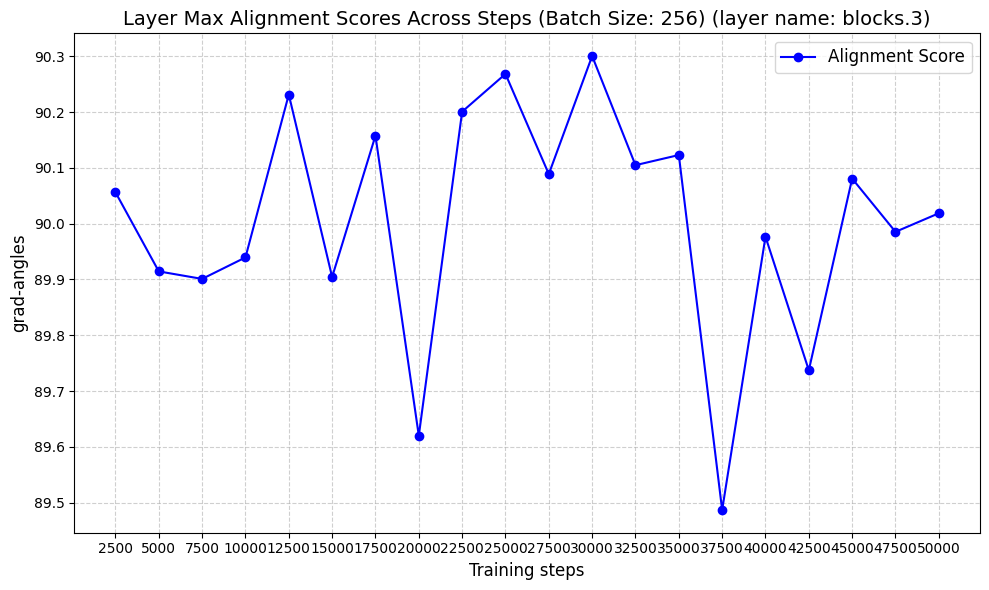

In [21]:
# Plot the trend
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(steps, grad_angles, marker='o', linestyle='-', color='b', label='Alignment Score')
plt.title(f"Layer Max Alignment Scores Across Steps (Batch Size: {args.batch_size}) (layer name: {layer_name})", fontsize=14)
plt.xlabel("Training steps", fontsize=12)
plt.ylabel("grad-angles", fontsize=12)
# plt.ylim(0, 1)
plt.xticks(steps)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

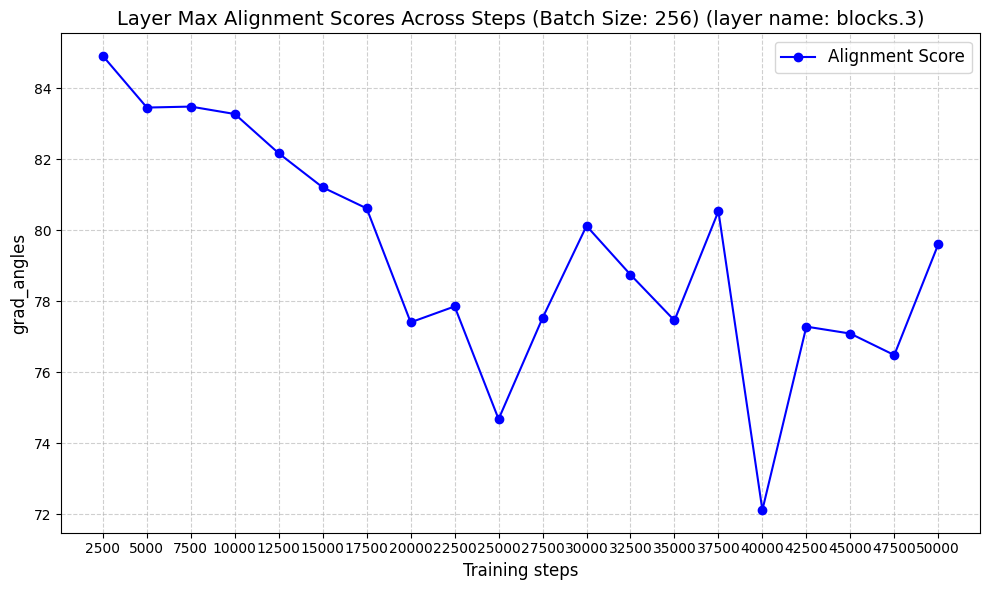

In [16]:
# Plot the trend
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(steps, grad_angles, marker='o', linestyle='-', color='b', label='Alignment Score')
plt.title(f"Layer Max Alignment Scores Across Steps (Batch Size: {args.batch_size}) (layer name: {layer_name})", fontsize=14)
plt.xlabel("Training steps", fontsize=12)
plt.ylabel("grad_angles", fontsize=12)
# plt.ylim(0, 1)
plt.xticks(steps)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

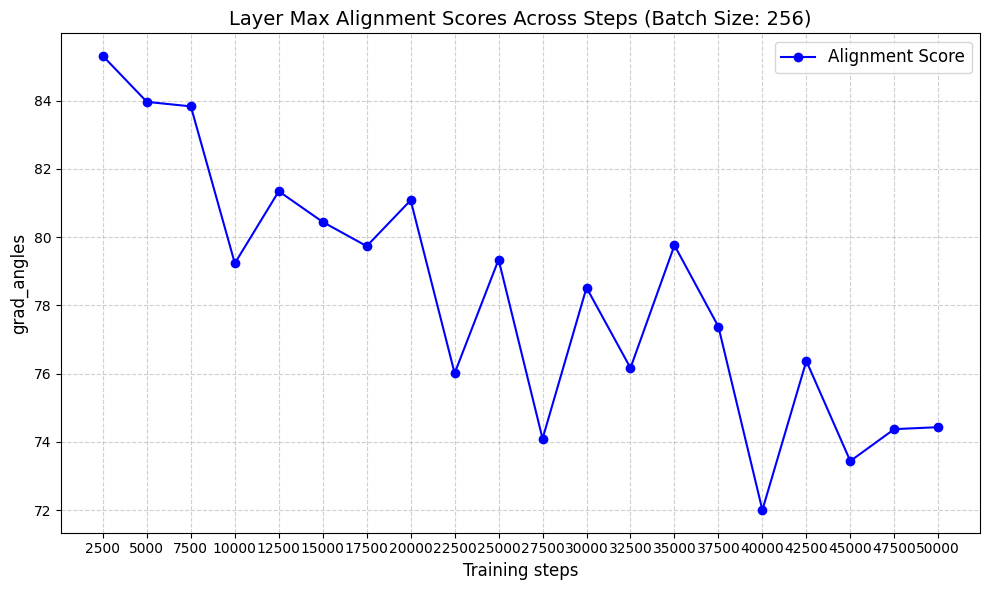

In [46]:
# Plot the trend
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(steps, grad_angles, marker='o', linestyle='-', color='b', label='Alignment Score')
plt.title(f"Layer Max Alignment Scores Across Steps (Batch Size: {args.batch_size})", fontsize=14)
plt.xlabel("Training steps", fontsize=12)
plt.ylabel("grad_angles", fontsize=12)
# plt.ylim(0, 1)
plt.xticks(steps)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


## 4.1 - Detach one head before ka loss

In [25]:
# hyperparams
batch_size=128
topk=10
layer_start=6
layer_end=10
use_projection = False
t_start = 0.49
t_end = 0.51
temp = 0.2

# extract features
features = get_batch_features(
    model=model,
    vae=vae,
    encoders=encoders,
    encoder_types=encoder_types,
    architectures=architectures,
    train_dataset=train_dataset,
    loss_fn=loss_fn,
    device=device,
    batch_size=batch_size,
    use_projection=use_projection,
    t_start=t_start,
    t_end=t_end,
)

In [48]:
import torch.nn.functional as F

def patch2patch_kernel_alignment_score(feats_A, feats_B, detach_grad=False):
    """
    feats_A: B, N, D
    feats_B: B, N, E # can be different from dimension
    """
    # normalize the features along the last dimension
    feats_A = F.normalize(feats_A, dim=-1)
    feats_B = F.normalize(feats_B, dim=-1)

    # compute the kernel matrix --> patch2patch similarity matrix for both A and B # B, N, N
    if detach_grad:
        feats_A_ = feats_A.clone().detach()
    else:
        feats_A_ = feats_A
    kernel_matrix_A = feats_A @ feats_A_.transpose(1, 2)
    kernel_matrix_B = feats_B @ feats_B.transpose(1, 2)

    # normalize the rows for both kernel matrices
    kernel_matrix_A = F.normalize(kernel_matrix_A, dim=-1)
    kernel_matrix_B = F.normalize(kernel_matrix_B, dim=-1)

    # compute the similarity of the kernel matrices between A and B
    # Since each row is now a unit vector, the dot product of corresponding rows
    # will be 1 if they are identical.
    alignment_score = (kernel_matrix_A * kernel_matrix_B).sum(dim=-1)  # B, N

    # average the alignment score across the patches (dim=1) and then across the samples (dim=0)
    alignment_score = alignment_score.mean(dim=1).mean(dim=0)
    return alignment_score


def sample2sample_kernel_alignment_score(feats_A, feats_B, detach_grad=False):
    """
    feats_A: B, N, D
    feats_B: B, N, E
    """
    # take the mean across last dimension # B, D
    feats_A = feats_A.mean(dim=-2)
    feats_B = feats_B.mean(dim=-2)

    # normalize the features along the last dimension
    feats_A = F.normalize(feats_A, dim=-1)
    feats_B = F.normalize(feats_B, dim=-1)

    # compute the kernel matrix --> sample2sample similarity matrix for both A and B # B, B
    if detach_grad:
        feats_A_ = feats_A.clone().detach()
    else:
        feats_A_ = feats_A
    kernel_matrix_A = feats_A @ feats_A.transpose(0, 1)
    kernel_matrix_B = feats_B @ feats_B.transpose(0, 1)

    # normalize the rows for both kernel matrices
    kernel_matrix_A = F.normalize(kernel_matrix_A, dim=-1)
    kernel_matrix_B = F.normalize(kernel_matrix_B, dim=-1)

    # compute the similarity of the kernel matrices between A and B
    # Since each row is now a unit vector, the dot product of corresponding rows
    # will be 1 if they are identical.
    alignment_score = (kernel_matrix_A * kernel_matrix_B).sum(dim=-1)  # B

    # average the alignment score across the samples
    alignment_score = alignment_score.mean(dim=0)
    return alignment_score

In [55]:
# Import necessary libraries
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ensure reproducibility
torch.manual_seed(42)

def optimize_model(
    model, 
    vae, 
    encoders, 
    encoder_types, 
    architectures, 
    train_dataset, 
    loss_fn, 
    kernel_alignment_score, 
    args, 
    device='cuda', 
    batch_size=8,
    use_projection=True, 
    t_start=0.,
    t_end=1.,
    num_epochs=10,
    learning_rate=1e-3,
    steps_per_epoch=100,  # Number of optimization steps per epoch,
    detach_grad=False,
):
    """
    Optimizes the model parameters to minimize the kernel alignment score between fs and zs_tilde.

    Parameters:
    - model: The model to be optimized.
    - vae: The VAE model.
    - encoders: List of encoder models.
    - encoder_types: List of encoder types.
    - architectures: List of architectures.
    - train_dataset: The training dataset.
    - loss_fn: The loss function with interpolant method.
    - kernel_alignment_score: The kernel alignment score function.
    - args: Argument parser containing the checkpoint path.
    - device: Device to run the optimization on ('cuda' or 'cpu').
    - batch_size: Batch size.
    - use_projection: Whether to use projection in the model.
    - t_start: Start of time input range.
    - t_end: End of time input range.
    - num_epochs: Number of epochs.
    - learning_rate: Learning rate for optimizer.
    - steps_per_epoch: Number of optimization steps per epoch.

    Returns:
    - loss_history: List of loss values over all optimization steps.
    """
    # Move model to the specified device
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()

    # Load the model weights from checkpoint
    if not os.path.exists(args.ckpt):
        raise FileNotFoundError(f"Checkpoint file not found at {args.ckpt}")
    
    state_dict = torch.load(args.ckpt, map_location=device)
    
    # If the checkpoint has a nested state_dict (e.g., under 'ema'), handle accordingly
    if isinstance(state_dict, dict) and 'ema' in state_dict:
        state_dict = state_dict['ema']
    
    model.load_state_dict(state_dict)
    print("Model weights loaded successfully.")

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize DataLoader
    dataloader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=2, 
        pin_memory=True
    )

    # Precompute DataLoader iterator
    dataloader_iterator = iter(dataloader)

    # Setup scale/bias for latents
    latents_scale = torch.tensor([0.18215]*4).view(1,4,1,1).to(device)
    latents_bias = torch.tensor([0.0]*4).view(1,4,1,1).to(device)

    loss_history = []

    # Optimization loop
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for step in progress_bar:
            try:
                # Get a batch from DataLoader
                raw_image, x, y = next(dataloader_iterator)
            except StopIteration:
                # Reinitialize the iterator if it runs out
                dataloader_iterator = iter(dataloader)
                raw_image, x, y = next(dataloader_iterator)

            # Move data to device
            raw_image = raw_image.to(device)
            x = x.squeeze(dim=1).to(device)  # Assuming x has an extra dimension to squeeze
            y = y.to(device)
            labels = y  # Handle label processing if needed

            # Convert VAE latents to model latents
            with torch.no_grad():
                x = sample_posterior(x, latents_scale=latents_scale, latents_bias=latents_bias)

            # Extract encoder features
            zs = []
            with torch.no_grad():
                for encoder, encoder_type, arch in zip(encoders, encoder_types, architectures):
                    raw_image_preprocessed = preprocess_raw_image(raw_image, encoder_type)
                    z = encoder.forward_features(raw_image_preprocessed)
                    if 'mocov3' in encoder_type:
                        z = z[:, 1:]
                    if 'dinov2' in encoder_type:
                        z = z['x_norm_patchtokens']
                    zs.append(z)

            # Sample a random time step (uniform weighting)
            time_input = torch.rand((x.shape[0], 1, 1, 1), device=device, dtype=x.dtype)
            # Limit to the given range
            time_input = time_input * (t_end - t_start) + t_start

            # Compute interpolant
            alpha_t, sigma_t, d_alpha_t, d_sigma_t = loss_fn.interpolant(time_input)
            noises = torch.randn_like(x)
            model_input = alpha_t * x + sigma_t * noises
            model_target = d_alpha_t * x + d_sigma_t * noises

            # Forward pass through the model to get zs_tilde and predictions
            model_output, zs_tilde, fs, all_layer_feats = model(
                model_input, 
                time_input.flatten(), 
                y=labels, 
                use_projection=use_projection
            )

            # Ensure zs_tilde and fs are detached from the computation graph if necessary
            # If you want to optimize only certain parts, adjust accordingly
            # Here, we assume both fs and zs_tilde require gradients for optimization
            # If zs_tilde should not require gradients, set detach_grad=True in kernel_alignment_score

            # Compute kernel alignment score loss
            loss = -kernel_alignment_score(zs_tilde[0], zs[0], detach_grad=detach_grad)

            # Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Record loss
            loss_value = loss.item()
            loss_history.append(loss_value)
            epoch_loss += loss_value

            # Update progress bar
            progress_bar.set_postfix({'Loss': f"{loss_value:.4f}"})

        avg_epoch_loss = epoch_loss / steps_per_epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}")

    # Plot the loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label='Kernel Alignment Loss')
    plt.xlabel('Optimization Steps')
    plt.ylabel('Loss')
    plt.title('Kernel Alignment Loss Minimization')
    plt.legend()
    plt.grid(True)
    plt.show()

    return loss_history

/tmp/ipykernel_62738/3131856310.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(args.ckpt, map_location=device)


Model weights loaded successfully.


Epoch [1/1], Average Loss: -0.9542


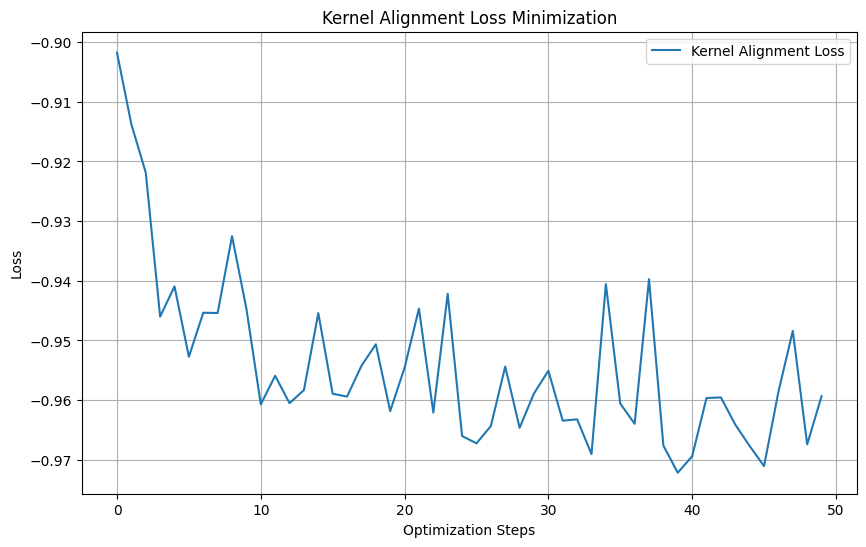

Model weights loaded successfully.


Epoch [1/1], Average Loss: -0.9548


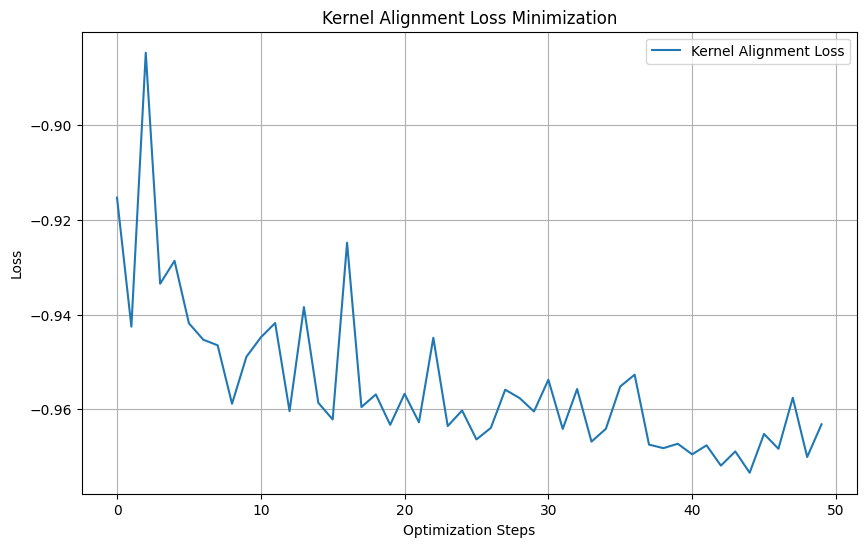

In [56]:
loss_history_ = []
for detach_grad in [False, True]:
    # Call the optimization function
    loss_history = optimize_model(
        model=model,
        vae=vae,
        encoders=encoders,
        encoder_types=encoder_types,
        architectures=architectures,
        train_dataset=train_dataset,
        loss_fn=loss_fn,
        # kernel_alignment_score=patch2patch_kernel_alignment_score,
        kernel_alignment_score=sample2sample_kernel_alignment_score,
        args=args,  # Contains the checkpoint path
        device='cuda:3',          # Change to 'cpu' if CUDA is not available
        batch_size=32,
        use_projection=False,
        t_start=0.,
        t_end=1.,
        num_epochs=1,          # Number of epochs for optimization
        learning_rate=1e-4,     # Learning rate for the optimizer
        steps_per_epoch=50,     # Number of steps per epoch
        detach_grad=detach_grad,
    )
    loss_history_.append(loss_history)

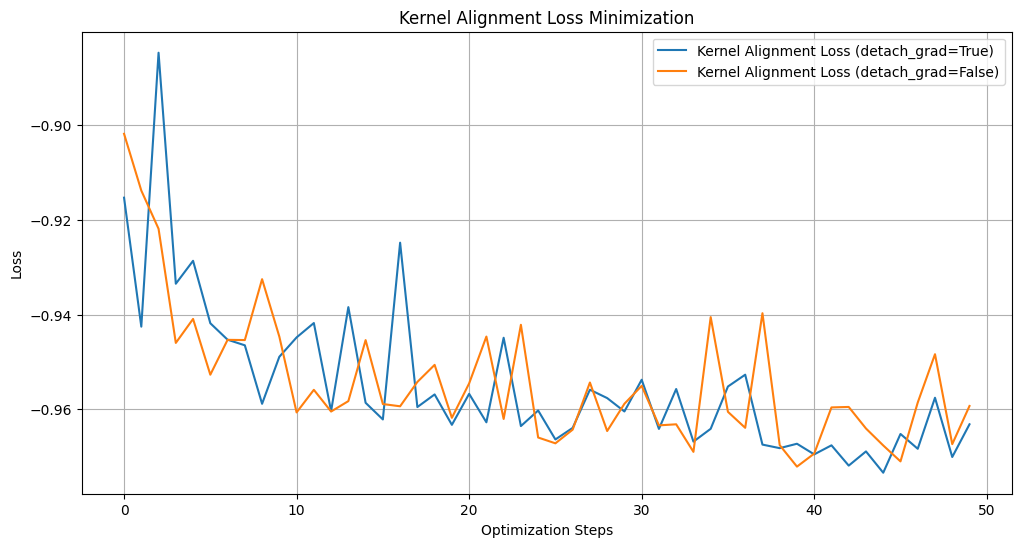

In [57]:
# Plot the loss curves
plt.figure(figsize=(12, 6))
plt.plot(loss_history_[1], label='Kernel Alignment Loss (detach_grad=True)')
plt.plot(loss_history_[0], label='Kernel Alignment Loss (detach_grad=False)')
plt.xlabel('Optimization Steps')
plt.ylabel('Loss')
plt.title('Kernel Alignment Loss Minimization')
plt.legend()
plt.grid(True)
plt.show()

# Debug